<a href="https://colab.research.google.com/gist/solcigp/b510f4c2ebe6fa08627ca6fea380677d/proyecto-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cancer de Mamas

URL Del Dataset https://www.kaggle.com/datasets/gunesevitan/breast-cancer-metabric

Objetivo (Abstract) En base a los datos tales como las características del cáncer de los diferentes pacientes (como así también el tratamiento que se siguió) vamos a buscar demostrar la efectividad de algunos tratamientos sobre otros en base a las características de los pacientes. En este dataset vamos a poder trabajar con valores asociados a tipos de tratamiento, edades, tamaños, la fase de la enfermedad, entre otros. Creemos que con la información con la que contamos podemos obtener una base para obtener sugerencias de tratamientos y su grado de efectividad dependiendo del estado de la enfermedad. Además, contamos con algunas variables que podrían ser interesantes para el uso en nuestro proyecto. Algunas de ellas son por ej., la edad (para encontrar una relación entre el cáncer y los diferentes rangos etáreos), los diferentes tipos de cáncer buscando clasificarlos, el subtipo de cáncer (según el grado de afectación en cada paciente), la lateralidad del tumor (buscando relación con otras variables según la ubicación del cáncer) y por último, pero no por ello menos importante, el overall survival status (o % de sobreviviente) para cuantificar cuántos pudieron atravesarlo de manera exitosa. De esta manera buscaremos responder algunas preguntas del tipo:

¿Hay una relación entre el tratamiento de la quimioterapia y la supevivencia de las pacientes? ¿Hay una relación entre el tamaño del turmor y la supervivencia? Estas preguntas fueron abordadas a consideración de los gráficos que se pudieron lograr mediante el uso de diferentes librerías y fundamentadas en el dataset elegido. Como se podrá verificar en los diferentes gráficos, existen algunos fundamentos que permiten correlacionar distintas variables para inferir conclusiones relativas al tratamiento del Cáncer de mamas. Asimismo, en otras ocasiones no se pudo concluir de manera determinante que existiera una relación y en consecuencia, no se arribó a una conclusión tajante. Por lo anteriormente expresado, podemos decir que existen ciertos aspectos que son determinantes para demostrar una relación entre la enfermedad y sus diferentes variables (como en la Fase del Tumor detectado vs Tamaño del Tumor según edades) y otras en la que la evidencia es muy pareja en la muestra (Edad del Diagnostico vs Estado Vital)

La idea sería construir un modelo predictivo para proveer de las mejores alternativas posibles en base al estado general del paciente y el avance de la enfermedad.

##Contexto Comercial

Esta enfermedad se manifiesta de diversas maneras en los pacientes y así también son las maneras de tratarla, a partir de la información provista por el dataset quisieramos inferir ¿cúal es el mejor tratamiento en base a las caracteristicas genereles del paciente?


##Problema Comercial

¿Hay un tratamiento y/o combinación de factores que determinen una mayor probabilidad de éxito en la lucha con la enfermdedad?

In [ ]:
#Acceso a Google Drive
from google.colab import drive
drive.mount('/content/drive')
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 

Mounted at /content/drive


In [ ]:
#1. Instala las librerias
! pip3 install kaggle
! pip3 install featuretools
! pip3 install chart_studio # era parte de plotly, ahora es independiente
! pip3 install bqplot # para hacer dinamicos los graficos en colab
! pip3 install pingouin # paquetes estadistico para hacer pruebas estadisticas

#2. Crea el directorio .kaggle
! mkdir ~/.kaggle

#3. Copia el archivo “kaggle.json” a la carpeta nueva
! cp kaggle.json ~/.kaggle/

#4. Cambia los permisos para el arvhivo
! chmod 600 ~/.kaggle/kaggle.json

#5. API de GoogleDrive
! pip3 install -U -q PyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
#IMPORTACIÓN LIBRERIAS

import pandas as pd
from scipy import stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import chart_studio.plotly as py
from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
import pingouin
bokeh.io.output_notebook(INLINE)
from bokeh.models import Scatter
# featuretools para automatizar feature engineering
#matplotlit y  seaborn para visualizaciones
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns
#Warnings de Pandas
import warnings
warnings.filterwarnings('ignore')
#Modelado
import lightgbm as lgb
#Uttilidades
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
#Manejo de memoria
import gc
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

#EDA

#Contexto analítico - Preparación del dataset

El mismo cuenta con 2509 registros.

La información del dataset se compone de perfiles médicos de distintos pacientes y como transitan, o transitaron la enfermedad, los tratamientos que realizaron, la variante y fase de la misma, etc.

Los datos que proveen los mismos son de diversos tipos:

continuos (edad)
lógicos (quimioterapia)
categoricos (celularidad)

Análisis de algunas Variables
Vamos a trabajar con las siguientes columnas:
Age At Diagnosis - Edad en la que obtuvo el diagnostico

Cancer Type - Tipo de Cancer

Type of Breast Surgery - Subtipo de cancer

Cancer Type Detailed - Tipo de Cancer Específico

Cellularity - Proporción del cancer residual en el paciente

Chemotherapy - Determina si el paciente realizó quimioterapia o no

Neoplasm Histologic Grade - Esta columna determina la graduación del tipo de tumor, permite determinar la velocidad de mutación de las celulas

Mutation Count - Este indicador puede servir como un marcador biológico para predecir si el paciente va a responder a la quimioterapia o la inmunoterapia

Overall Survival (Months) - Supervivencia en general medida en meses

Overall Survival Status - Estado actual de supervivencia del paciente

Relapse Free Status (Months) - Tiempo en meses libre de recaida

Relapse Free Status - Estado del paciente si sigue sin recaidas o no.

Tumor Size - Tamaño del tumor

Tumor Stage - Fase en la que se encuentra la enfermedad

Patient's Vital Status - Estado vital del paciente

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autenticacion y creacion de PyDrive 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Exportamos el dataset
link = 'https://drive.google.com/file/d/17B3RF8t1-VG_k9avtvLP7By1HXQOOhEP/view?usp=share_link'

import pandas as pd

#Para encontrar el ID del archivo
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Breast_cancer.csv')

Breast_cancer= pd.read_csv('Breast_cancer.csv')

Breast_cancer.head()

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [ ]:
#Informacion sobre tamaño de tabla Test
Breast_cancer.shape

(2509, 34)

In [ ]:
#Informacion sobre contenido y tipo de datos en tabla Train
Breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Patient ID                      2509 non-null   object 
 1   Age at Diagnosis                2498 non-null   float64
 2   Type of Breast Surgery          1955 non-null   object 
 3   Cancer Type                     2509 non-null   object 
 4   Cancer Type Detailed            2509 non-null   object 
 5   Cellularity                     1917 non-null   object 
 6   Chemotherapy                    1980 non-null   object 
 7   Pam50 + Claudin-low subtype     1980 non-null   object 
 8   Cohort                          2498 non-null   float64
 9   ER status measured by IHC       2426 non-null   object 
 10  ER Status                       2469 non-null   object 
 11  Neoplasm Histologic Grade       2388 non-null   float64
 12  HER2 status measured by SNP6    19

In [ ]:
#Informacion estadistica de las distintas columnas
Breast_cancer.describe()

,Age at Diagnosis,Cohort,Neoplasm Histologic Grade,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Relapse Free Status (Months),Tumor Size,Tumor Stage
count,2498.000000,2498.000000,2388.000000,2243.000000,2357.000000,2287.000000,1981.000000,2388.000000,2360.000000,1788.000000
mean,60.420300,2.900320,2.412060,1.950513,5.578702,4.028787,125.244271,108.842487,26.220093,1.713647
std,13.032997,1.962216,0.649363,4.017774,3.967967,1.189092,76.111772,76.519494,15.370883,0.655307
min,21.930000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,50.920000,1.000000,2.000000,0.000000,3.000000,3.048000,60.866667,40.560000,17.000000,1.000000
50%,61.110000,3.000000,3.000000,0.000000,5.000000,4.044000,116.466667,99.095000,22.410000,2.000000
75%,70.000000,4.000000,3.000000,2.000000,7.000000,5.040000,185.133333,167.640000,30.000000,2.000000
max,96.290000,9.000000,3.000000,45.000000,80.000000,7.200000,355.200000,384.210000,182.000000,4.000000


In [ ]:
#Filtrado de columnas para mejor analisis, cambio de nombre de la columna 
Breast_analisis = Breast_cancer.iloc[:, [1,2,4,5,6,26,31,32,33,16,20] ]

len(Breast_analisis)

Breast_analisis.rename(columns={'Patient\'s Vital Status':'Vital Status'}, inplace = True)

#Preguntas a las cuales les buscamos respuesta
En este apartado se encuentran una serie de preguntas ante las cuales estamos buscando respuesta a través del análisis de gráficos generados en base al dataset.

##Es la quimioterapia un tratamiento con menor cantidad de pacientes con muerte por cancer?


(array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.]),
 <a list of 11 Text major ticklabel objects>)

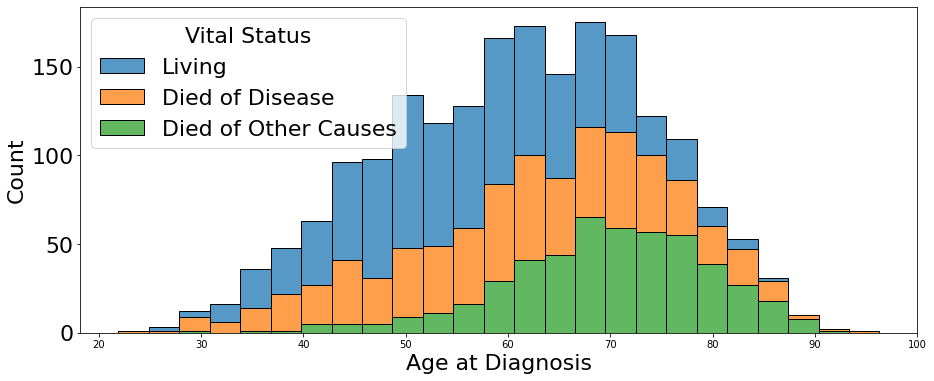

In [ ]:
#Contamos la cantida de pacientes por edad del paciente en cada uno de los estados
from matplotlib.figure import figaspect
import seaborn            as sb
plt.figure(figsize=(15,6))
fig= sb.histplot(data=Breast_analisis, x="Age at Diagnosis",multiple="stack", hue="Vital Status")
plt.xticks(fontsize=10)

Con este grafico vemos como esta la distribucion de la edad entre los estados

In [ ]:
#Veamos el estado vital general de los pacientes de la muestra
total = Breast_analisis.shape[0]
Breast_analisisLiving = Breast_analisis["Vital Status"] == "Living"	
Breast_analisisDiedother = Breast_analisis["Vital Status"] == "Died of Other Causes"	
Breast_analisisDieddisease = Breast_analisis["Vital Status"] == "Died of Disease"	

porcentaje_living = Breast_analisisLiving.sum() / total *100
porcentaje_died_disease = Breast_analisisDieddisease.sum() / total *100
porcentaje_died_other = Breast_analisisDiedother.sum() / total *100

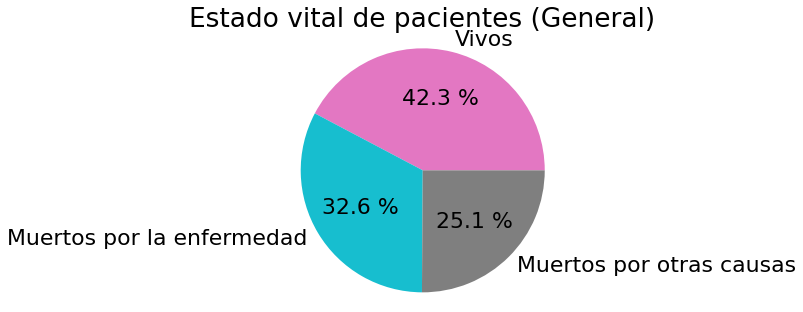

In [ ]:
#Graficamos el porcentaje de la muestra por cada uno de los estados
Nombres = np.array(["Vivos", "Muertos por la enfermedad", "Muertos por otras causas"])
Porcentaje = np.array([porcentaje_living,porcentaje_died_disease,porcentaje_died_other])
plt.figure(figsize=(7,5)) #tamaño del grafico
plt.title("Estado vital de pacientes (General)") #titulo del grafico
pie_colors = ['tab:pink', 'tab:cyan', 'tab:grey']
plt.pie(Porcentaje, labels=Nombres, autopct="%0.1f %%", colors=pie_colors)
plt.axis("equal")
plt.show()

In [ ]:
Tratados = Breast_analisis.loc[Breast_analisis.Chemotherapy == "Yes"]
Totaltratados = Tratados.shape[0]

Tratadosvivos = Tratados["Vital Status"] == "Living"
Tratadosmuertos = Tratados["Vital Status"] == "Died of Other Causes"
Tratadosmuertosotras = Tratados["Vital Status"] == "Died of Disease"	

porcentaje_Tratadosvivo = Tratadosvivos.sum() / Totaltratados *100
porcentaje_Muertoenfermo = Tratadosmuertos.sum() / Totaltratados *100
porcentaje_Muertootras = Tratadosmuertosotras.sum() / Totaltratados *100

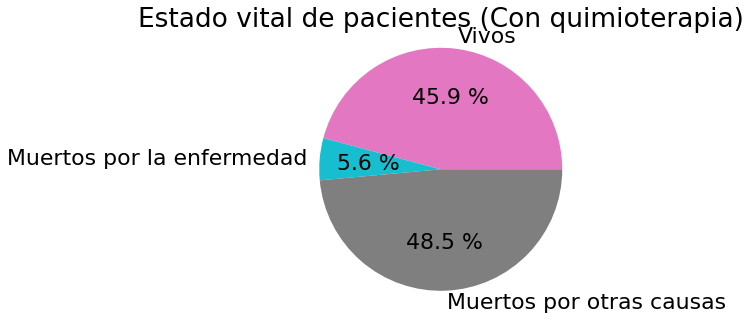

In [ ]:
#Graficamos el porcentaje de los pacientes que recibieron quimioterapia como tratamiento y el resultado de su estado vital
Nombres = np.array(["Vivos", "Muertos por la enfermedad", "Muertos por otras causas"])
Porcentaje = np.array([porcentaje_Tratadosvivo,porcentaje_Muertoenfermo,porcentaje_Muertootras])
plt.figure(figsize=(7,5)) #tamaño del grafico
plt.title("Estado vital de pacientes (Con quimioterapia)") #titulo del grafico
pie_colors = ['tab:pink', 'tab:cyan', 'tab:grey']
plt.pie(Porcentaje, labels=Nombres, autopct="%0.1f %%", colors=pie_colors)
plt.axis("equal")
plt.show()

Con este analisis podemos ver que las pacientes que reciben quimioterapia reducen la probabilidad de no fallecer a causa del cancer. Tambien consideramos que la edad de las pacientes que fallecen por otras causas es mayor a los 60 años.

Probamos la relacion entre la edad del diagnostico y otras variables. 


In [ ]:
Breast_analisis.replace({"Living": "1", "Died of Disease": "2", "NaN ": "0", "Died of Other Causes": "3"})

,Age at Diagnosis,Type of Breast Surgery,Cancer Type Detailed,Cellularity,Chemotherapy,Radio Therapy,Tumor Size,Tumor Stage,Vital Status,Inferred Menopausal State,Mutation Count
0,75.65,Mastectomy,Breast Invasive Ductal Carcinoma,NaN,No,Yes,22.0,2.0,1,Post,NaN
1,43.19,Breast Conserving,Breast Invasive Ductal Carcinoma,High,No,Yes,10.0,1.0,1,Pre,2.0
2,48.87,Mastectomy,Breast Invasive Ductal Carcinoma,High,Yes,No,15.0,2.0,2,Pre,2.0
3,47.68,Mastectomy,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,Yes,25.0,2.0,1,Pre,1.0
4,76.97,Mastectomy,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,Yes,40.0,2.0,2,Post,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2504,70.05,NaN,Invasive Breast Carcinoma,NaN,NaN,NaN,27.0,1.0,NaN,NaN,2.0
2505,63.60,NaN,Invasive Breast Carcinoma,NaN,NaN,NaN,28.0,2.0,NaN,NaN,4.0
2506,NaN,NaN,Invasive Breast Carcinoma,NaN,NaN,NaN,NaN,0.0,NaN,NaN,6.0
2507,NaN,NaN,Invasive Breast Carcinoma,NaN,NaN,NaN,NaN,0.0,NaN,NaN,7.0


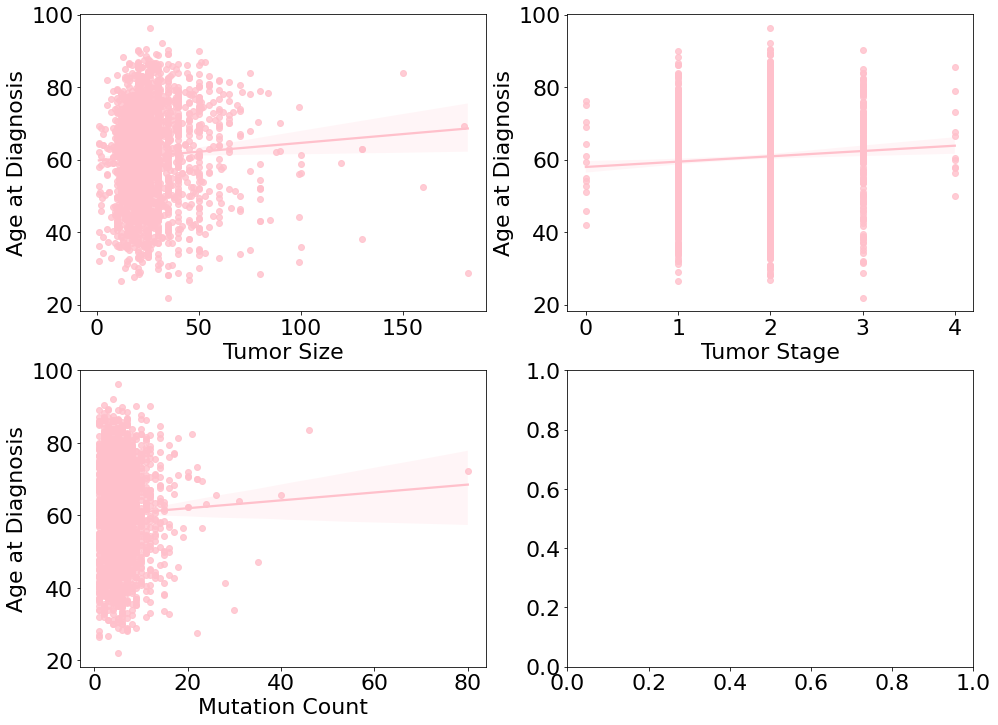

In [ ]:
#Probamos la relacion entre la edad del diagnostico y otras variables.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
DiagnosisrVstatus_plot = pd.concat([Breast_analisis['Age at Diagnosis'],Breast_analisis['Tumor Size']],axis = 1)
sns.regplot(x='Tumor Size',y = 'Age at Diagnosis',data = DiagnosisrVstatus_plot,scatter= True, fit_reg=True, ax=ax1, color="pink")
DiagnosisrVstatus_plot = pd.concat([Breast_analisis['Age at Diagnosis'],Breast_analisis['Tumor Stage']],axis = 1)
sns.regplot(x='Tumor Stage',y = 'Age at Diagnosis',data = DiagnosisrVstatus_plot,scatter= True, fit_reg=True, ax=ax2,color="pink")
DiagnosisrVstatus_plot = pd.concat([Breast_analisis['Age at Diagnosis'],Breast_analisis['Mutation Count']],axis = 1)
sns.regplot(x='Mutation Count',y = 'Age at Diagnosis',data = DiagnosisrVstatus_plot,scatter= True, fit_reg=True, ax=ax3,color="pink")

##Es el tamaño del tumor representativo en la supervivencia de la paciente?

Primero analizamos si la distribucion del tamaño del tumor es normal. Utilizamos Kurtosis para dicho analisis

In [ ]:
Breast_analisis.skew(), Breast_analisis.kurt()

(Age at Diagnosis   -0.155284
 Tumor Size          3.032792
 Tumor Stage         0.221406
 Mutation Count      4.809036
 dtype: float64, Age at Diagnosis    -0.581758
 Tumor Size          17.894032
 Tumor Stage          0.258393
 Mutation Count      63.000161
 dtype: float64)

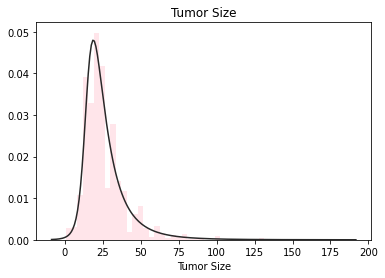

In [ ]:
#Graficamos para saber si la variable es asimentrica o no
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import scipy.stats as st
y = Breast_analisis['Tumor Size']
plt.figure(1); plt.title('Tumor Size')
sns.distplot(y, kde=False, color='pink', fit=st.johnsonsu)

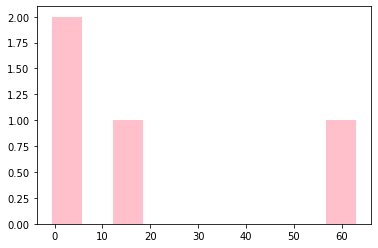

In [ ]:
plt.hist(Breast_analisis.kurt(),orientation = 'vertical',histtype = 'bar',label ='Kurtosis', color ='pink')
plt.show()

La distribucion de la muestra es asimetrica, por lo tanto podemos considerarla en el analisis que se muestra a continuacion

In [ ]:
#Corremos la matriz de correlacion ordenado de mayor a menos por columna SalePrice
corr_matrix = Breast_analisis.corr()
corr_matrix['Tumor Size'].sort_values(ascending=False)

Tumor Size          1.000000
Tumor Stage         0.491490
Age at Diagnosis    0.057769
Mutation Count      0.020010
Name: Tumor Size, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63f1838a90>]],
      dtype=object)

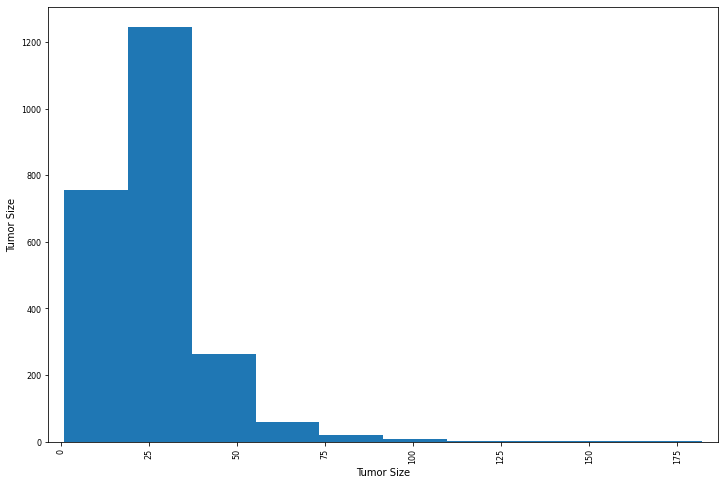

In [ ]:
#Desde Pandas importamos scatter_matrix para generar una matriz por atributos
from pandas.plotting import scatter_matrix
attributes = ["Tumor Size", "Type of Breast Surgery", "Vital Status"]
scatter_matrix(Breast_analisis[attributes], figsize = (12,8))

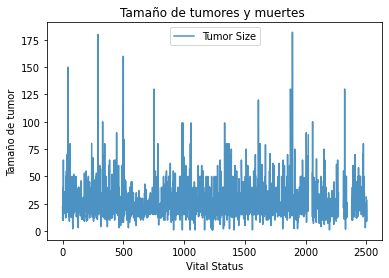

In [ ]:
#Creamos una comparacion entre el estado de vida y el tamaño del tumor 
Breast_analisis.plot(x="Vital Status", y="Tumor Size", alpha=0.8)
plt.title("Tamaño de tumores y muertes ")
plt.ylabel("Tamaño de tumor")#titulo 
plt.xticks(fontsize=10)
plt.xscale("linear")

Con este analisis podemos concluir que existe una correlacion entre el tamaño del turmo y la supervivencia de la paciente


#Modelo de Clasificacion


###Regresion



In [ ]:
from sklearn.ensemble import RandomForestClassifier # Usaremos como clasificador un bosque aleatorio
from sklearn.model_selection import train_test_split # vamos a separar nuestro dataset
from sklearn import metrics # vamos a medir el desempeño
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz # Para visualizar los árboles

In [ ]:
Breast_clean = Breast_analisis.replace({"Mastectomy": "1", "Breast Invasive Ductal Carcinoma" : "1","Breast Invasive Lobular Carcinoma":"5", "Breast Mixed Ductal and Lobular Carcinoma":"4", "Breast Invasive Ductal Carcinoma": "2","Breast":"0","Breast Invasive Mixed Mucinous Carcinoma":"6","Invasive Breast Carcinoma":"7", "Metaplastic Breast Cancer"
:"8","Breast Angiosarcoma":"9", "Breast Mixed Ductal and Lobular Carcinoma":"3", "Breast Conserving": "2", "Living": "1", "Died of Disease": "2", "NaN ": "0", "Died of Other Causes": "3",
"High":"3", "Moderate": "2", "Low":"1",
"No":"0", "Yes":"1",
"Post":"1", "Pre":"2",
"False":"1", "True":"2"})


In [ ]:
#Estandarizamos los datos
from sklearn.preprocessing import PowerTransformer
X = Breast_clean.drop("Vital Status", 1).values
y = Breast_clean['Vital Status']
Yeo=PowerTransformer(method='yeo-johnson').fit_transform(X)

In [ ]:
#Normalizamos la muestra
df_norm=pd.DataFrame(Yeo)
df_norm=df_norm.join(y)

In [ ]:
from sklearn.impute import SimpleImputer
X = pd.DataFrame(X)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0)
imputer = imputer.fit(X.iloc[:, 1:3])
X.iloc[:, 1:3] = imputer.transform(X.iloc[:, 1:3])

In [ ]:
Breast_clean = Breast_clean.dropna()

In [ ]:
#Selecciono variables para futuro analisis
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import array 
selector = SelectKBest(f_classif, k=5)
X = X.dropna()
selector.fit(X, y)


ValueError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(Breast_clean, test_size = 0.30, random_state = 100) 

In [ ]:
X_train

NameError: ignored

In [ ]:
y_train

In [ ]:
y_test

In [ ]:
#Separación en Train y Test
X = Breast_clean.drop("Vital Status", axis=1)
y = Breast_clean["Vital Status"]

In [ ]:
#Train y Test Split
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 

In [ ]:
#Regresion Lineal
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
#Recuperamos la intersección
print(regressor.intercept_)

In [ ]:
#La pendiente
print(regressor.coef_)

In [ ]:
#Hacemos nuestras predicciones
y_pred = regressor.predict(X_test)

In [ ]:
#Convertimos en df la salida
import pandas as pd
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

In [ ]:
#Evaluación de Modelos
from sklearn import metrics
import numpy as np
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
metrics.max_error(y_test,y_pred)

In [ ]:
metrics.median_absolute_error(y_test,y_pred)

In [ ]:
#Definicion aleatoria de la division de los dato entre entramiento y prueba
train, test = train_test_split(Breast_clean,test_size = 0.30)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para test: ", len(test))


###Arbol de decision

In [ ]:
from sklearn.ensemble import RandomForestClassifier # Usaremos como clasificador un bosque aleatorio
from sklearn.model_selection import train_test_split # vamos a separar nuestro dataset
from sklearn import metrics # vamos a medir el desempeño
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz # Para visualizar los árboles

In [ ]:
from sklearn.tree import DecisionTreeClassifier

target = 'Vital Status'
features = ["Tumor Stage","Age at Diagnosis", "Type of Breast Surgery"]

clf = DecisionTreeClassifier()
train, test = train_test_split(Breast_clean, test_size = 0.30)
clf = clf.fit(train[features], train[target])

In [ ]:
train, test = train_test_split(Breast_clean, test_size = 0.30, random_state = 100)


In [ ]:
#Graficamos el arbol de decision
features_response_ss = ['Tumor Stage', 'Type of Breast Surgery', 'Tumor Size', 'Age at Diagnosis']
Breast_clean.groupby('Vital Status')['Vital Status'].count()/len(Breast_clean)
X_train, X_test, y_train, y_test = train_test_split(Breast_clean[features_response_ss[:-1]].values, Breast_clean['Vital Status'].values,test_size=0.2, random_state=24)
dt = tree.DecisionTreeClassifier(max_depth=2) # Definición del modelo                
dt = dt.fit(X_train, y_train) # Ajustamos el modelo
dot_data = tree.export_graphviz(dt,
                                out_file=None,
                                filled=True,
                                rounded=True,
                                feature_names=features_response_ss[:-1],
                                proportion=True,
                                class_names=[
                                    'Died of Other Causes', 'Died of Disease', 'Living']) 
graph = graphviz.Source(dot_data) # Creamos las imagen del arbol
graph

In [ ]:
# from sklearn.datasets import load_breast_cancer # vamos a usar el dataset sobre cancer de mama
from sklearn.ensemble import RandomForestClassifier # Usaremos como clasificador un bosque aleatorio
from sklearn.model_selection import train_test_split # vamos a separar nuestro dataset
from sklearn import metrics # vamos a medir el desempeño
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

 # Separamos en entrenamiento/test en razon 80/20 %
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

# Creamos un modelo Random Forest con parametros por defect
modelo = RandomForestClassifier(random_state=1)
modelo.fit(X_train, y_train)
# Obtenemos las predicciones del modelo con X_test
preds = modelo.predict(X_test) 

In [ ]:

plt.figure(figsize=(10,6))
metrics.plot_confusion_matrix(modelo, X_test, y_test, display_labels=['ME', 'MOC', "Vive"])

No es un buen modelo. Muchos falsos positivos y postivos negativos

#Entrenamiento y Testeo



#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
rf = RandomForestClassifier(random_state=42, n_estimators=100, 
                               class_weight="balanced", max_features="log2") 
rf.fit(X_train, y_train)

In [ ]:
y_test_pred_rf = rf.predict(X_test)
y_train_pred_rf =rf.predict(X_train)

In [ ]:
plt.figure(figsize=(14,10))
importances = rf.feature_importances_
columns = X_test.columns
sns.barplot(columns, importances)
plt.title('Importancia de cada Feature en RandomForest')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred_rf))

#SCV

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
modelo = SVC(C=0.1,kernel='rbf',random_state=42)
modelo.fit(X_train, y_train)

In [ ]:
y_test_pred_scv = modelo.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred_scv))

In [ ]:
#Entrenamiento del modelo
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
y_pred_reg = regressor.predict(X_test)

In [ ]:
print(classification_report(y_test, y_test_pred_rf))

Conclusion

Como podemos ver en los modelos que utilizamos, es mejor medir este dataset con los Random Forest porque el nivel de precision es mayor.

#Revision de modelos con Stratified K Fold

Random Forest

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
(X_train, X_test,y_train, y_test) = train_test_split(X,y,stratify=y,test_size=0.30,random_state=42)
model = RandomForestClassifier(random_state=42, n_estimators=100, # n_estimators representa el numero de arboles a usar
                               class_weight="balanced", max_features="log2")
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test) #Prediccion en Test
y_test_pred
from sklearn.metrics import accuracy_score
#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación:',test_accuracy)

Validacion del modelo


In [ ]:
# Se incluye matriz de confusión 

from sklearn.metrics import confusion_matrix

matriz = confusion_matrix(y_test, y_test_pred)

print('Matriz de Confusión de datos de Test:')

print(matriz)

In [ ]:
# Reporte de clasificación o analisis de resultados.
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

Conclusion,

Ambos modelos nos estan dando buenos resultados de aciertos

Metodo de Ensamble

Utilizamos el algoritmo "XG Boost" para implementar optimizacion en nuestro modelo

In [ ]:
!pip install xgboost

In [ ]:

import xgboost as xgb #pip install xgboost
from sklearn.linear_model import LinearRegression as LR
X = Breast_clean.drop("Vital Status", axis=1)
y = Breast_clean["Vital Status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=123)
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=15,seed=42,max_depth=5, learning_rate=0.01)
clf_xgb.fit(X_train,y_train) #Entrenamos el modelo
y_test_pred = clf_xgb.predict(X_test) #Prediccion en Test
#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación:',test_accuracy)


In [ ]:
#Creamos el procedimiento Stratified K Fold 
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(Breast_clean.values, y.values)

In [ ]:
train, test=list(skf.split(Breast_clean.values, y.values))[0]

In [ ]:
list_f1=[]
list_sensibilidad=[]

# Iterate over the splits
for i in range(0,skf.get_n_splits(Breast_clean, y)):
    # Calculo de indices
    train, test = list(skf.split(Breast_clean, y))[i]
    # Separar train y test
    X_train_n=Breast_clean.iloc[train,:]
    X_test_n=Breast_clean.iloc[test,:]
    y_test_n= y[test]
    y_train_n=y[train]

    # Ajustar el modelo
    rf.fit(X_train_n, y_train_n)
    # Predicciones
    pred= rf.predict(X_test_n)
    # Calculo del error
    f1= f1_score(y_true=y)

In [ ]:
# Modelo vacio
list_f1=[]
list_sensibilidad=[]
for i in range(0,skf.get_n_splits(Breast_clean, y)):
  # Calculo de indices
  train, test = list(skf.split(Breast_clean.values, y))[i]
  # Separar train y test
  X_train_n=Breast_clean.values[train]
  X_test_n=Breast_clean.values[test]
  y_test_n= y_test[test]
  y_train_n=y_train[train]
 
  # Ajustar el modelo
  rf.fit(X_train_n, y_train_n)
  # Predicciones
  pred= rf.predict(X_test_n)
  # Calculo del error
  f1= f1_score(y_true=y_test_n, y_pred= pred)
  sensibilidad= recall_score(y_true=y_test_n, y_pred= pred)
  print('Iteracion: ',i+1, ' f1:', f1)
  print('Iteracion: ',i+1, ' Sensibilidad:', sensibilidad)
  list_f1.append(f1)
  list_sensibilidad.append(sensibilidad)
# Promedio de accuracy
import numpy as np
print('F1 promedio:', np.mean(list_f1))
print('Sensibilidad promedio:', np.mean(list_sensibilidad))

Arbol de decisión

In [ ]:
list_f1=[]
list_sensibilidad=[]
for i in range(0,skf.get_n_splits(Breast_clean, y)):
  # Calculo de indices
  train, test = list(skf.split(Breast_clean.values, y))[i]
  # Separar train y test
  X_train_n=Breast_clean.values[train]
  X_test_n=Breast_clean.values[test]
  y_test_n= y[test]
  y_train_n=y[train]
 
  # Ajustar el modelo
  tree.fit(X_train_n, y_train_n)
  # Predicciones
  pred= tree.predict(X_test_n)
  # Calculo del error
  f1= f1_score(y_true=y_test_n, y_pred= pred)
  sensibilidad= recall_score(y_true=y_test_n, y_pred= pred)
  print('Iteracion: ',i+1, ' f1:', f1, 'Sensibilidad', sensibilidad)
  list_f1.append(f1)
  list_sensibilidad.append(sensibilidad)
# Promedio de accuracy
import numpy as np
print('F1 promedio:', np.mean(list_f1))
print('Sensibilidad promedio:', np.mean(list_sensibilidad))

#Hypertuning con RandomizedSearchC

In [ ]:
#Importamos las librerias necesarias
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

Random Forest

In [ ]:
params_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
grid_cv = RandomizedSearchCV(rf, params_grid, scoring="f1", n_jobs=-1, cv=3)
grid_cv.fit(X_train, y_train)

print("Mejores parametros", grid_cv.best_params_)
print("Mejor score de CV", grid_cv.best_score_)
#print(f'Sensibilidad del modelo = {round(recall_score(y_test, grid_cv.predict(X_test)), 5)}')
#print(f'F1 del modelo = {round(f1_score(y_test, grid_cv.predict(X_test)), 5)}')

Conclusion Final
